# Sentiment analysis with Finnish AFINN models
#### - Polarity labels (from -5 to 5) as negative, neutral and positive
#### - For original HS dataset of 'raw' and 'corrected' samples
#### - Preprocessing and AFINN based classification

### This script was published as a part of research work
This script was created and published by Merja Kreivi-Kauppinen.

This script is part of research work carried at University of Oulu in 2020-2023.

Topic of research work and thesis:
'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'

### Method of sentiment analysis with afinn

Social media text polarity (multilabel) sentiment classification with afinn SA was carried on lemmatized samples, where words, emoticons and emojis were used to get sentiment scoring for text samples. 

Emoticons and emojis were taken into account in sentiment scoring.

Scoring was carried for 'raw' text samples and manually 'corrected' text samples.

Scoring with afinn was carried in three steps: (1) only for emoticons, (2) only for words, and (3) only for emojis.

 - (1) Text samples were tokenized with NLTK 'WhitespaceTokenizer' before emoticon scoring.

 - (2) Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens. Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to afinn scoring process.

 - (3) Emojis of text samples were changed to english word forms before emoji scoring.

All three sentiment scores of text sample were fetched together, and after removal of zero values, the final scoring result of a sample was achieved by calculating the mean of scores.

The NaN results were set to zero, and the sample values above zero was rounded up (indicating positive label) and the sample values above zero was rounded down (indicating negative label).

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for multilabel classifier.

### Original afinn available in GitHub
Original version of Afinn method available at GitHub: https://github.com/fnielsen/afinn

Reference: Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

### Finnish AFINN lexicon for multilabel polarity sentiment classification of Finnish (social media) text samples

Documentation of FINNfin library available as README.

Finnish AFINN for polarity classification of Finnish social media text uses lexicon which includes basic, pended, subword and lemma forms of words and their polarity labels (from -5 to 5).

All lexicons (words, emoticons, emojis) were provided on lexicographically descending order to enable more precise text, emoticon, symbol and emoji matching.

 - On emotion lexicon 'fin_afinn_polarity_MerjasList_2023.txt' each word is labeled with one sentiment label (between -5 and 5)
 
 - On emoticon lexicon 'afinn_emoticon_polarity_MerjasList_2023.txt' each emoticon is labeled with one sentiment label (between -5 and 5)
 
 - On emoji lexicon 'afinn_emoji_polarity_MerjasList_2023.txt' each emoji is labeled with one sentiment label (between -5 and 5)


### The original AFINN method was sligthly modified before application to binary classification

New script available at file AFINN_scores.py

Changes in original script.
The Original AFinn class was replaced with

    - AFinnEmoticons class,
    
    - AFinnWords class, and
    
    - AfinnEmojis class

The AFinnWords class was used with 'word_boundary=True' flag to enable more precise text matching.

The AFinnWords class includes small changes in script.

New flags were added to AFinnEmoticons and AFinnEmojos classes.
The AFinnEmoticons and AFinnEmojis classes can be used with 
'emoticons_only=True' or 'emoticons_only=True' flag 
to enable text sample matching with emoticons or emojis only.

     - AFinnEmoticons class has 'emoticons_only' flag
     
     - AFinnEmojis class has 'emojis only' flag


## Import and check  jupyter python installations, packages. and libraries

In [1]:
# import python packages and libraries

import sys, re, os
import numpy as np
import pandas as pd

import string, math 
import time, datetime, random

print(f"\nPython Version: {sys.version} \n")
print(sys.executable)
print(sys.version)
print(sys.version_info)
print('\njupyter version: \n')
!jupyter --version

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split



Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

C:\Users\merja\anaconda3\envs\NLPtfgpu\python.exe
3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

jupyter version: 

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.16.0
ipywidgets       : 8.0.2
jupyter_client   : 7.4.2
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.0
nbconvert        : 7.2.1
nbformat         : 5.7.0
notebook         : 6.4.12
qtconsole        : not installed
traitlets        : 5.4.0
The scikit-learn version is 1.1.2.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)

## Import NLP packages and AFINN for Finnish

In [3]:
import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

import emoji
from emoji import *
import functools
import operator

## Import Experimental Spacy and Voikko

In [4]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

Spacy Version: 3.5.0


In [5]:
# Test large Finnish model

# Load large Finnish model
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test the model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [6]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())


Current working directory  C:\Users\merja\Desktop\HS_research_project\AFINN_sentiment_analysis


In [7]:
# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)

Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names as keys and property values as values.
 |  
 |  attributeValues(self, attributeName)

In [8]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]


In [9]:
# get Voikko version
print("Voikko version:  ", Voikko.getVersion())

Voikko version:   4.3


In [10]:
# Test experimental Finnish Spacy model with Spacy

# Load large Finnish model
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


# Testing AFINN scoring for text data in dataframe

In [11]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
csv_file = 'Balanced_Dataset_Collection_ALL_2023Merja.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
#df

In [12]:
# Change text samples to string
df["stringSample"] = df[str("sample")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringSample"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.stringSample.str.len()
    return df

extract_stringLen(df)
df.head(50)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength
0,- - opetustilanteisiin,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116
4,=) kristiina ja anna jatkoon! =),positive,3,False,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,False,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69
6,=DW =,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,=DW =,6
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,False,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217


In [13]:
# change HS / not HS values
df['HSbinary'] = df['HSbinary'].replace(False, 0)
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df.tail(40)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength
15968,äärimmäisen vittuuntunut.,negative,-5,1,1,NONE,OPINION,SWEARING,Meria,äärimmäisen vittuuntunut.,25
15969,äärivassarit vittuun,negative,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",Meria,äärivassarit vittuun,20
15970,Ääs-viduilija,negative,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",Meria,Ääs-viduilija,13
15971,äää vittu mikä räkis,negative,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED",Meria,äää vittu mikä räkis,20
15972,Äääärimamuttajat,negative,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",Meria,Äääärimamuttajat,16
15973,äääää...vittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,äääää...vittu,13
15974,äääääähläm,negative,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",Meria,äääääähläm,10
15975,öbkibvbvittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,öbkibvbvittu,12
15976,öitääääääää!😴😴,neutral,1,0,0,NaN,NaN,NaN,Meria,öitääääääää!😴😴,14
15977,ÖkyrikkaatKURIINvittu,negative,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",Meria,ÖkyrikkaatKURIINvittu,21


In [14]:
df['HSbinary'].value_counts()

0    11555
1     4453
Name: HSbinary, dtype: int64

## AFINN scores for emoticons

In [15]:
# Tokenization of raw samples - with Whitespace tokenization
df['sample_WTokens'] = df["stringSample"].apply(lambda row: WhitespaceTokenizer().tokenize(str(row)))


In [16]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emoticons
AFINN_fin_EMOTICONS = AFINNfin.AFINN_scores.AfinnEmoticons(language='fin', emoticons=True, emoticons_only=True)

# ---------------------------------------------------------------------------------
# Get emoticon scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_AFemoc_val'] = df.apply(lambda x: add_score_items_to_list(x['sample_WTokens']), axis=1)
df.head(103)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[]
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[]
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1]
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",90,"[""Ja, heinrichs, &amp;, co, sopivat, suomen, h...",[]
99,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",96,"[""Ja, hän, vetäytyi, heistä, noin, kivenheiton...",[]
100,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",220,"[""Ja, kun, tämä, uudestisyntymisen, ihme, tapa...",[]
101,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",155,"[""Ja, nyt, nettiliikenne, toimii, kuin, hidast...",[]


## Lemmatization with experimental Fin Spacy and AFINN scores for words

In [17]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =)
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,"[=), Sussa, vaan, on, jotakin, mikä, saa, tän,...","[1, 2]",=) sussa vaan olla joka mikä saada tän tyttö...
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,"[=DW, =]",[1],= DW =
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,"[-, 4-vuotias, tyttö, kokeillessaan, ensimmäis...",[],- 4-vuotias tyttö kokeilla ensimmäinen kerta s...
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,"[-, Akateemisuus, vaalii, Sokrateen, ym.]",[],- akateemisuus vaalia Sokrates ym.
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y...",[],- alhainen ikä - hyvin korkea ikä - ylipaino -...


In [18]:
# Tokenization of raw samples with casual tokenization
df['sampleTokens'] = df['sampleLemmas'].apply(lambda row:casual_tokenize(row))
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]"
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, Playboy, vuosi, 1972, l..."
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, Suomi, myydä, ..."
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), Kristiina, ja, antaa, jatko, !, =)]"
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,"[=), Sussa, vaan, on, jotakin, mikä, saa, tän,...","[1, 2]",=) sussa vaan olla joka mikä saada tän tyttö...,"[=), sussa, vaan, olla, joka, mikä, saada, tän..."
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,"[=DW, =]",[1],= DW =,"[=, DW, =]"
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,"[-, 4-vuotias, tyttö, kokeillessaan, ensimmäis...",[],- 4-vuotias tyttö kokeilla ensimmäinen kerta s...,"[-, 4, -, vuotias, tyttö, kokeilla, ensimmäine..."
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,"[-, Akateemisuus, vaalii, Sokrateen, ym.]",[],- akateemisuus vaalia Sokrates ym.,"[-, akateemisuus, vaalia, Sokrates, ym, .]"
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y...",[],- alhainen ikä - hyvin korkea ikä - ylipaino -...,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y..."


In [19]:
# lower samples
df['sampleTokens'] = df['sampleTokens'].apply(lambda row: [token.lower() for token in row])
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]"
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,..."
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l..."
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ..."
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]"
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,69,"[=), Sussa, vaan, on, jotakin, mikä, saa, tän,...","[1, 2]",=) sussa vaan olla joka mikä saada tän tyttö...,"[=), sussa, vaan, olla, joka, mikä, saada, tän..."
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,6,"[=DW, =]",[1],= DW =,"[=, dw, =]"
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,57,"[-, 4-vuotias, tyttö, kokeillessaan, ensimmäis...",[],- 4-vuotias tyttö kokeilla ensimmäinen kerta s...,"[-, 4, -, vuotias, tyttö, kokeilla, ensimmäine..."
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,35,"[-, Akateemisuus, vaalii, Sokrateen, ym.]",[],- akateemisuus vaalia Sokrates ym.,"[-, akateemisuus, vaalia, sokrates, ym, .]"
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,217,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y...",[],- alhainen ikä - hyvin korkea ikä - ylipaino -...,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y..."


In [20]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish words
# initialize afinn sentiment analyzer for lemmatized Finnish
AFINN_fin = AFINNfin.AFINN_scores.AfinnWords(language='fin')

# ---------------------------------------------------------------------------------
# Get word scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list

df['sample_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['sampleTokens']), axis=1)
df.head(103)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]",[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]"
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]"
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]"
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",90,"[""Ja, heinrichs, &amp;, co, sopivat, suomen, h...",[],""" ja Heinrichs & amp ; co sopia suomi hyökkäys...","["", ja, heinrichs, &, amp, ;, co, sopia, suomi...",[3]
99,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",96,"[""Ja, hän, vetäytyi, heistä, noin, kivenheiton...",[],""" ja hän vetäytyä hän noin kivenheitto pää , l...","["", ja, hän, vetäytyä, hän, noin, kivenheitto,...","[-1, -1, 1, -1, 1]"
100,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",220,"[""Ja, kun, tämä, uudestisyntymisen, ihme, tapa...",[],""" ja kun tämä uudestisyntyminen ihme tapahtua ...","["", ja, kun, tämä, uudestisyntyminen, ihme, ta...","[4, 1, 1, 3, 4, 1, 2, 1, 3, 2, 2]"
101,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",155,"[""Ja, nyt, nettiliikenne, toimii, kuin, hidast...",[],""" ja nyt nettiliikenne toimia kuin hidastettu ...","["", ja, nyt, nettiliikenne, toimia, kuin, hida...","[1, 1, -2, 1]"


# AFINN scores for emojis

In [21]:
# emoji analyze
df['emoji_analyze'] = df['sample'].apply(lambda row: emoji.analyze(row))
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14,[😂😂😂😂😂😂😂😂😂😂😂😂😂😂],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]",[],<generator object filter_tokens at 0x000001E2B...
16004,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5,[😠👉👩‍💼],[],😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]",[],<generator object filter_tokens at 0x000001E2B...
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10,[🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],<generator object filter_tokens at 0x000001E2B...
16006,🤮😡,negative,-4,0,0,NaN,NaN,NaN,Meria,🤮😡,2,[🤮😡],[],🤮 😡,"[🤮, 😡]",[],<generator object filter_tokens at 0x000001E2B...


In [22]:
# emoji tokens
df['emoji_tokens'] = df['emoji_analyze'].apply(lambda row: [token.value.emoji for token in row])
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...,[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[]
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...,[]
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...,[]
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14,[😂😂😂😂😂😂😂😂😂😂😂😂😂😂],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]",[],<generator object filter_tokens at 0x000001E2B...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]"
16004,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5,[😠👉👩‍💼],[],😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]",[],<generator object filter_tokens at 0x000001E2B...,"[😠, 👉, 👩‍💼]"
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10,[🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],<generator object filter_tokens at 0x000001E2B...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]"
16006,🤮😡,negative,-4,0,0,NaN,NaN,NaN,Meria,🤮😡,2,[🤮😡],[],🤮 😡,"[🤮, 😡]",[],<generator object filter_tokens at 0x000001E2B...,"[🤮, 😡]"


In [23]:
# emoji definitions
df['demojize'] = df['emoji_tokens'].apply(lambda row: [emoji.demojize(token) for token in row])
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,22,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...,[],[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",85,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[]
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,51,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...,[],[]
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,116,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[]
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),34,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,positive,5,0,0,NaN,NaN,NaN,Meria,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,14,[😂😂😂😂😂😂😂😂😂😂😂😂😂😂],[],😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂 😂,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]",[],<generator object filter_tokens at 0x000001E2B...,"[😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂, 😂]","[:face_with_tears_of_joy:, :face_with_tears_of..."
16004,😠👉👩‍💼,negative,-3,0,0,NaN,NaN,NaN,Meria,😠👉👩‍💼,5,[😠👉👩‍💼],[],😠 👉 👩 ‍ 💼,"[😠, 👉, 👩, ‍ , 💼]",[],<generator object filter_tokens at 0x000001E2B...,"[😠, 👉, 👩‍💼]","[:angry_face:, :backhand_index_pointing_right:..."
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,positive,5,0,0,NaN,NaN,NaN,Meria,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,10,[🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣],[],🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣 🤣,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]",[],<generator object filter_tokens at 0x000001E2B...,"[🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣, 🤣]","[:rolling_on_the_floor_laughing:, :rolling_on_..."
16006,🤮😡,negative,-4,0,0,NaN,NaN,NaN,Meria,🤮😡,2,[🤮😡],[],🤮 😡,"[🤮, 😡]",[],<generator object filter_tokens at 0x000001E2B...,"[🤮, 😡]","[:face_vomiting:, :enraged_face:]"


In [24]:
# import AFINN folder
import AFINNfin
# import Afinn form AFINNfin for Finnish 
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish with emojis
AFINN_fin_EMOJIS = AFINNfin.AFINN_scores.AfinnEmojis(language='fin', emojis=True, emojis_only=True)     

# ---------------------------------------------------------------------------------
# Get emoji scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin_EMOTICONS.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list
    
df['sample_emoji_values'] = df.apply(lambda row: add_score_items_to_list(row['demojize']), axis=1)
df.tail(20)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,stringLength,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values
15988,ÖÖ T:VITTU,negative,-4,1,2,NONE,TROLLING,SWEARING,Meria,ÖÖ T:VITTU,10,"[ÖÖ, T:VITTU]",[],ÖÖ T:VITTU,"[öö, t, :, vittu]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15989,ÖÖ7jaKuolemanKurvit,negative,-2,0,0,NaN,NaN,NaN,Meria,ÖÖ7jaKuolemanKurvit,19,[ÖÖ7jaKuolemanKurvit],[],öö7jakuolemankurvit,[öö7jakuolemankurvit],[],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15990,ööliä vittu,negative,-4,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",Meria,ööliä vittu,11,"[ööliä, vittu]",[],ööliä vittu,"[ööliä, vittu]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15991,öö-luokkalaiset.vittuun,negative,-5,1,2,NONE,TROLLING,"JOKE SARCASM, SWEARING",Meria,öö-luokkalaiset.vittuun,23,[öö-luokkalaiset.vittuun],[],öö-luokkalaiset.vittuun,"[öö-luokkalaiset, ., vittuun]",[],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15992,öö-vittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,öö-vittu,8,[öö-vittu],[],öö-vittu,[öö-vittu],[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15993,ööö,negative,-1,0,0,NaN,NaN,NaN,Meria,ööö,3,[ööö],[],ööö,[ööö],[],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15994,Ööö mitä vittua??,negative,-4,1,2,NONE,OPINION,"JOKE SARCASM, SWEARING",Meria,Ööö mitä vittua??,17,"[Ööö, mitä, vittua??]",[],Ööö mitä vittu ? ?,"[ööö, mitä, vittu, ?, ?]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15995,Ööövittuentiiä,negative,-5,1,2,NONE,"OPINION, TROLLING","SWEARING, GRANULATED",Meria,Ööövittuentiiä,14,[Ööövittuentiiä],[],ööövittuentiiä,[ööövittuentiiä],[],<generator object filter_tokens at 0x000001E2B...,[],[],[]
15996,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",positive,5,0,0,NaN,NaN,NaN,Meria,"👍❤Hyvä Ville, sinua on ilo kuunnella, nautin a...",101,"[👍❤Hyvä, Ville,, sinua, on, ilo, kuunnella,, n...",[],"👍 ❤ hyvä Ville , sinä olla ilo kuunnella , nau...","[👍, ❤, hyvä, ville, ,, sinä, olla, ilo, kuunne...","[2, 0, 3, 2, 3, 0, 2]",<generator object filter_tokens at 0x000001E2B...,"[👍, ❤]","[:thumbs_up:, :red_heart:]",[]
15997,👍🏻,positive,1,0,0,NaN,NaN,NaN,Meria,👍🏻,2,[👍🏻],[],👍 🏻,"[👍, 🏻]",[],<generator object filter_tokens at 0x000001E2B...,[👍🏻],[:thumbs_up_light_skin_tone:],[]


# Check the value validity of measurements

In [25]:
def check_value_validity_string(column_value):
    for values in column_value:
        splitted = values.split(",")
        for item in splitted:    
            item = item.strip()
            if item:
                try:
                    as_float = float(item)
                    if as_float > 5.0 or as_float < -5.0:
                        print(str(as_float))
                except:
                    # use try except to pass [] characters
                    print("Found non float , moving forward ...")


def check_value_validity_float(column_value, index):
    for value in column_value:        
        if value > 5.0 or value < -5.0:
            print(index, str(value))
            #print(index)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
i = 0
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)                    

print("For column sample_AFemoc_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFemoc_val'], x.name), axis=1)

print("For column sample_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFword_val'], x.name), axis=1)

print("For column sample_emoji_values : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_emoji_values'], x.name), axis=1)


For column sample_emoji_values : 
 ----------------------------- 
For column sample_AFemoc_val : 
 ----------------------------- 
For column sample_AFword_val : 
 ----------------------------- 
For column sample_emoji_values : 
 ----------------------------- 


0        None
1        None
2        None
3        None
4        None
         ... 
16003    None
16004    None
16005    None
16006    None
16007    None
Length: 16008, dtype: object

# Summary column

In [26]:
df['sample_values'] = df.apply(lambda row: row['sample_AFemoc_val'] + row['sample_AFword_val'] + row['sample_emoji_values'], axis=1)
df.head(103)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,...,sample_WTokens,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,...,"[-, -, opetustilanteisiin]",[],- - opetustilanne,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",...,"[-, ""Treenaa"", ja, bailaa, kuten, ennenkin, -,...",[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 0, 1, 0, -2, 1]"
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,...,"[=, Minulle, on, tullut, Playboy, vuodesta, 19...",[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[0, 1]"
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,...,"[=), (Juuri, sellaiset, joita, suomessa, myydä...",[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, -1, 1, 2, 2, 2, 1]"
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),...,"[=), kristiina, ja, anna, jatkoon!, =)]","[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",...,"[""Ja, heinrichs, &amp;, co, sopivat, suomen, h...",[],""" ja Heinrichs & amp ; co sopia suomi hyökkäys...","["", ja, heinrichs, &, amp, ;, co, sopia, suomi...",[3],<generator object filter_tokens at 0x000001E2B...,[],[],[],[3]
99,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",...,"[""Ja, hän, vetäytyi, heistä, noin, kivenheiton...",[],""" ja hän vetäytyä hän noin kivenheitto pää , l...","["", ja, hän, vetäytyä, hän, noin, kivenheitto,...","[-1, -1, 1, -1, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[-1, -1, 1, -1, 1]"
100,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",...,"[""Ja, kun, tämä, uudestisyntymisen, ihme, tapa...",[],""" ja kun tämä uudestisyntyminen ihme tapahtua ...","["", ja, kun, tämä, uudestisyntyminen, ihme, ta...","[4, 1, 1, 3, 4, 1, 2, 1, 3, 2, 2]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[4, 1, 1, 3, 4, 1, 2, 1, 3, 2, 2]"
101,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",...,"[""Ja, nyt, nettiliikenne, toimii, kuin, hidast...",[],""" ja nyt nettiliikenne toimia kuin hidastettu ...","["", ja, nyt, nettiliikenne, toimia, kuin, hida...","[1, 1, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 1, -2, 1]"


In [27]:
def remove_zeros_and_add_to_column(column_value):
    trimmed_list = []
    #splitted = column_value.split(",")
    for item in column_value:    
        item = str(item).strip()
        if item:
            as_float = float(item)
            if as_float > 0.0 or as_float < 0.0:
                if as_float > 5.0 or as_float < -5.0:
                    print(str(as_float))
                trimmed_list.append(as_float)
    return trimmed_list
    
df['sample_scores'] = df.apply(lambda x: remove_zeros_and_add_to_column(x['sample_values']), axis=1)
df.head(103)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,...,sample_AFemoc_val,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,sample_scores
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,...,[],- - opetustilanne,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[]
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",...,[],"- "" treenata "" ja bailata kuten ennen - syödä ...","[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 0, 1, 0, -2, 1]","[1.0, 1.0, -2.0, 1.0]"
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,...,[],= minä olla tulla Playboy vuosi 1972 lähtien .,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[0, 1]",[1.0]
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,...,[1],=) ( juuri sellainen joka Suomi myydä halpah...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, -1, 1, 2, 2, 2, 1]","[1.0, -1.0, 1.0, 2.0, 2.0, 2.0, 1.0]"
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),...,"[1, 1]",=) Kristiina ja antaa jatko ! =),"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 1, 1]","[1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja heinrichs &amp; co sopivat suomen hyökkäys...",...,[],""" ja Heinrichs & amp ; co sopia suomi hyökkäys...","["", ja, heinrichs, &, amp, ;, co, sopia, suomi...",[3],<generator object filter_tokens at 0x000001E2B...,[],[],[],[3],[3.0]
99,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja hän vetäytyi heistä noin kivenheiton päähä...",...,[],""" ja hän vetäytyä hän noin kivenheitto pää , l...","["", ja, hän, vetäytyä, hän, noin, kivenheitto,...","[-1, -1, 1, -1, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[-1, -1, 1, -1, 1]","[-1.0, -1.0, 1.0, -1.0, 1.0]"
100,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja kun tämä uudestisyntymisen ihme tapahtuu,n...",...,[],""" ja kun tämä uudestisyntyminen ihme tapahtua ...","["", ja, kun, tämä, uudestisyntyminen, ihme, ta...","[4, 1, 1, 3, 4, 1, 2, 1, 3, 2, 2]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[4, 1, 1, 3, 4, 1, 2, 1, 3, 2, 2]","[4.0, 1.0, 1.0, 3.0, 4.0, 1.0, 2.0, 1.0, 3.0, ..."
101,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"""Ja nyt nettiliikenne toimii kuin hidastetussa...",...,[],""" ja nyt nettiliikenne toimia kuin hidastettu ...","["", ja, nyt, nettiliikenne, toimia, kuin, hida...","[1, 1, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 1, -2, 1]","[1.0, 1.0, -2.0, 1.0]"


# Calculate mean (or median)

In [28]:
df['sample_mean'] = df['sample_scores'].apply(lambda row: np.mean(row))
df.tail(40)

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,...,sampleLemmas,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,sample_scores,sample_mean
15968,äärimmäisen vittuuntunut.,negative,-5,1,1,NONE,OPINION,SWEARING,Meria,äärimmäisen vittuuntunut.,...,äärimmäinen vittuuntunut .,"[äärimmäinen, vittuuntunut, .]","[-1, -5]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[-1, -5]","[-1.0, -5.0]",-3.000000
15969,äärivassarit vittuun,negative,-5,1,2,COMMUNITY,POLITICS,"DISCRIMINATION, SWEARING",Meria,äärivassarit vittuun,...,äärivassarit vittu,"[äärivassarit, vittu]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[],[-5],[-5.0],-5.000000
15970,Ääs-viduilija,negative,-5,1,2,PERSON,OTHER,"INSULT, SWEARING, BULLY, GRANULATED",Meria,Ääs-viduilija,...,ääs-viduilija,[ääs-viduilija],[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN
15971,äää vittu mikä räkis,negative,-5,1,2,NONE,OPINION,"SWEARING, GRANULATED",Meria,äää vittu mikä räkis,...,äää vittu mikä räkis,"[äää, vittu, mikä, räkis]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[],[-5],[-5.0],-5.000000
15972,Äääärimamuttajat,negative,-2,1,1,COMMUNITY,IMMIGRATION,"INSULT, DISCRIMINATION, IDIOM, BULLY, GRAN...",Meria,Äääärimamuttajat,...,äääärimamuttajat,[ääärimamuttajat],[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN
15973,äääää...vittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,äääää...vittu,...,äääää ... vittu,"[äää, ..., vittu]",[-5],<generator object filter_tokens at 0x000001E2B...,[],[],[],[-5],[-5.0],-5.000000
15974,äääääähläm,negative,-3,1,2,COMMUNITY,"FOREIGN, TROLLING","INSULT, GRANULATED",Meria,äääääähläm,...,äääääähläm,[ääähläm],[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN
15975,öbkibvbvittu,negative,-5,1,2,NONE,OTHER,"SWEARING, GRANULATED",Meria,öbkibvbvittu,...,öbkibvbvittu,[öbkibvbvittu],[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN
15976,öitääääääää!😴😴,neutral,1,0,0,NaN,NaN,NaN,Meria,öitääääääää!😴😴,...,öitääääääää ! 😴 😴,"[öitäää, !, 😴, 😴]",[],<generator object filter_tokens at 0x000001E2B...,"[😴, 😴]","[:sleeping_face:, :sleeping_face:]","[-2, -2]","[-2, -2]","[-2.0, -2.0]",-2.000000
15977,ÖkyrikkaatKURIINvittu,negative,-5,1,2,GROUP,STATUS,"SWEARING, GRANULATED",Meria,ÖkyrikkaatKURIINvittu,...,ÖkyrikkaatKURIINvittu,[ökyrikkaatkuriinvittu],[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN


In [29]:
# set NaN values to zero
# set round values
# set values to integers

df['sample_mean_results'] = df['sample_mean'].replace(np.nan, 0)
df.loc[df['sample_mean_results'] > 0, 'sample_mean_results'] = df['sample_mean_results'].apply(np.ceil)
df.loc[df['sample_mean_results'] < 0, 'sample_mean_results'] = df['sample_mean_results'].apply(np.floor)
df['sample_mean_results'] = df['sample_mean_results'].astype('int')
df.head(50)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,user_nick,stringSample,...,sampleTokens,sample_AFword_val,emoji_analyze,emoji_tokens,demojize,sample_emoji_values,sample_values,sample_scores,sample_mean,sample_mean_results
0,- - opetustilanteisiin,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- - opetustilanteisiin,...,"[-, -, opetustilanne]",[],<generator object filter_tokens at 0x000001E2B...,[],[],[],[],[],NaN,0
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",...,"[-, "", treenata, "", ja, bailata, kuten, ennen,...","[1, 0, 1, 0, -2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 0, 1, 0, -2, 1]","[1.0, 1.0, -2.0, 1.0]",0.250000,1
2,= Minulle on tullut Playboy vuodesta 1972 läh...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,= Minulle on tullut Playboy vuodesta 1972 läh...,...,"[=, minä, olla, tulla, playboy, vuosi, 1972, l...","[0, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[0, 1]",[1.0],1.000000,1
3,=) (Juuri sellaiset joita suomessa myydään ha...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=) (Juuri sellaiset joita suomessa myydään ha...,...,"[=), (, juuri, sellainen, joka, suomi, myydä, ...","[-1, 1, 2, 2, 2, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, -1, 1, 2, 2, 2, 1]","[1.0, -1.0, 1.0, 2.0, 2.0, 2.0, 1.0]",1.142857,2
4,=) kristiina ja anna jatkoon! =),positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) kristiina ja anna jatkoon! =),...,"[=), kristiina, ja, antaa, jatko, !, =)]",[1],<generator object filter_tokens at 0x000001E2B...,[],[],[],"[1, 1, 1]","[1.0, 1.0, 1.0]",1.000000,1
5,=) Sussa vaan on jotakin mikä saa tän tytön p...,positive,3,0,0,NaN,NaN,NaN,FinnSentiment,=) Sussa vaan on jotakin mikä saa tän tytön p...,...,"[=), sussa, vaan, olla, joka, mikä, saada, tän...","[0, 1, 1, 0]",<generator object filter_tokens at 0x000001E2A...,[],[],[],"[1, 2, 0, 1, 1, 0]","[1.0, 2.0, 1.0, 1.0]",1.250000,2
6,=DW =,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,=DW =,...,"[=, dw, =]",[],<generator object filter_tokens at 0x000001E2A...,[],[],[],[1],[1.0],1.000000,1
7,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- 4-vuotias tyttö kokeillessaan ensimmäistä ke...,...,"[-, 4, -, vuotias, tyttö, kokeilla, ensimmäine...",[],<generator object filter_tokens at 0x000001E2A...,[],[],[],[],[],NaN,0
8,- Akateemisuus vaalii Sokrateen ym.,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- Akateemisuus vaalii Sokrateen ym.,...,"[-, akateemisuus, vaalia, sokrates, ym, .]",[2],<generator object filter_tokens at 0x000001E2B...,[],[],[],[2],[2.0],2.000000,2
9,- alhainen ikä - hyvin korkea ikä - ylipaino -...,neutral,0,0,0,NaN,NaN,NaN,FinnSentiment,- alhainen ikä - hyvin korkea ikä - ylipaino -...,...,"[-, alhainen, ikä, -, hyvin, korkea, ikä, -, y...","[-3, 2, 1, -1, 1, -2, 1, 1]",<generator object filter_tokens at 0x000001E2B...,[],[],[],"[-3, 2, 1, -1, 1, -2, 1, 1]","[-3.0, 2.0, 1.0, -1.0, 1.0, -2.0, 1.0, 1.0]",0.000000,0


# Polarity results for 'raw' and 'correct' samples

In [30]:
# change values to sring
df['sample_mean_results'] = df['sample_mean_results'].astype('int32')

# count values of each label type
df['sample_mean_results'].value_counts()

 0    4042
 1    3050
-1    2312
 2    2161
-2    1456
-5    1224
 3     652
-3     543
-4     413
 4     129
 5      26
Name: sample_mean_results, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN polarity values'}, ylabel='sample_mean_results'>

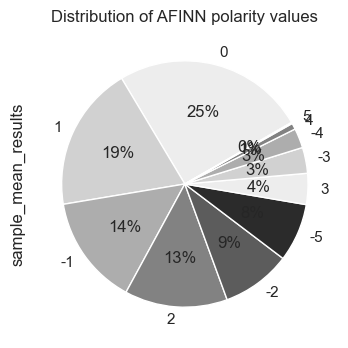

In [31]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['sample_mean_results'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN polarity values')

# Results analysis for 'raw' samples

In [32]:
# create panda dataframe for results
df_results = pd.DataFrame({'sample':df['sample'], 'sentiment':df['polarity'], 'prediction':df['sample_mean_results']})
df_results

,sample,sentiment,prediction
0,- - opetustilanteisiin,0,0
1,"- ""Treenaa"" ja bailaa kuten ennenkin - Syö asi...",0,1
2,= Minulle on tullut Playboy vuodesta 1972 läh...,0,1
3,=) (Juuri sellaiset joita suomessa myydään ha...,0,2
4,=) kristiina ja anna jatkoon! =),3,1
...,...,...,...
16003,😂😂😂😂😂😂😂😂😂😂😂😂😂😂,5,-1
16004,😠👉👩‍💼,-3,1
16005,🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣,5,0
16006,🤮😡,-4,-1


In [33]:
sentiments = df_results['sentiment'].tolist()
predictions = df_results['prediction'].tolist()

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5']

print(classification_report(sentiments, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

          -5       0.77      0.29      0.42      3324
          -4       0.07      0.05      0.06       624
          -3       0.09      0.06      0.07       797
          -2       0.04      0.14      0.06       431
          -1       0.02      0.20      0.03       218
           0       0.36      0.28      0.32      5259
           1       0.01      0.22      0.01        94
           2       0.02      0.17      0.04       276
           3       0.15      0.05      0.07      2182
           4       0.18      0.02      0.04      1177
           5       0.38      0.01      0.01      1626

    accuracy                           0.17     16008
   macro avg       0.19      0.13      0.10     16008
weighted avg       0.36      0.17      0.21     16008



In [35]:
print(confusion_matrix(sentiments, predictions))

[[ 948  269  243  335  241 1226   50    6    6    0    0]
 [ 106   29   42   78  102  224   37    3    3    0    0]
 [  89   52   48  132  121  282   61    8    4    0    0]
 [  34   11   42   60   79  150   46    7    2    0    0]
 [   8    4   10   38   44   64   38   10    2    0    0]
 [  31   28  115  614 1192 1471 1318  403   66   18    3]
 [   0    1    3    5    9   34   21   11    7    3    0]
 [   1    4    3   14   47   51   68   48   34    6    0]
 [   6    8   31  138  326  304  748  495   99   20    7]
 [   0    4    2   22   93  124  341  431  131   23    6]
 [   1    3    4   20   58  112  322  739  298   59   10]]


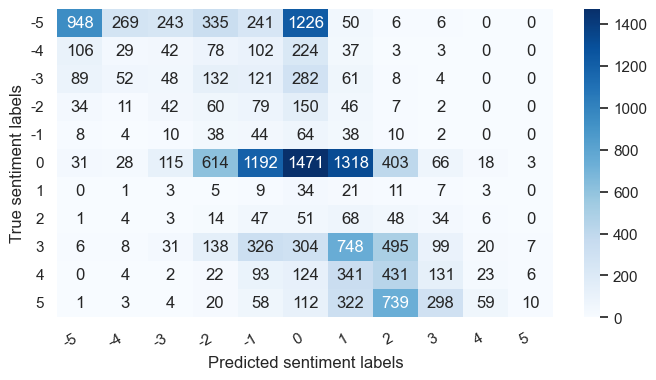

In [36]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment labels')
    plt.xlabel('Predicted sentiment labels');

cm = confusion_matrix(sentiments, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
total_accuracy = accuracy_score(sentiments, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
total_f1 = f1_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('F1  ', total_f1)

# calculate precision
total_precision = precision_score(predictions, sentiments, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Precision  ', total_precision)

# calculate recall
total_recall = recall_score(sentiments, predictions, average='weighted', labels=np.unique(predictions), zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.17497501249375313
F1   0.21251330870846172
Precision   0.20554577461263884
Recall   0.17497501249375313


In [38]:
#pip install pycm==4.0
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=sentiments, predict_vector=predictions)
cm.classes

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

In [39]:
cm.print_matrix()

Predict    -5         -4         -3         -2         -1         0          1          2          3          4          5          
Actual
-5         948        269        243        335        241        1226       50         6          6          0          0          

-4         106        29         42         78         102        224        37         3          3          0          0          

-3         89         52         48         132        121        282        61         8          4          0          0          

-2         34         11         42         60         79         150        46         7          2          0          0          

-1         8          4          10         38         44         64         38         10         2          0          0          

0          31         28         115        614        1192       1471       1318       403        66         18         3          

1          0          1          3          5          9

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [40]:
cm.print_normalized_matrix()

Predict       -5            -4            -3            -2            -1            0             1             2             3             4             5             
Actual
-5            0.2852        0.08093       0.0731        0.10078       0.0725        0.36883       0.01504       0.00181       0.00181       0.0           0.0           

-4            0.16987       0.04647       0.06731       0.125         0.16346       0.35897       0.05929       0.00481       0.00481       0.0           0.0           

-3            0.11167       0.06524       0.06023       0.16562       0.15182       0.35383       0.07654       0.01004       0.00502       0.0           0.0           

-2            0.07889       0.02552       0.09745       0.13921       0.18329       0.34803       0.10673       0.01624       0.00464       0.0           0.0           

-1            0.0367        0.01835       0.04587       0.17431       0.20183       0.29358       0.17431       0.04587       0.00917       0.0 

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:169: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [41]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.85
F1 Macro                                                          0.10264
FPR Macro                                                         0.08406
Kappa                                                             0.06704
NPV Macro                                                         0.91513
Overall ACC                                                       0.17498
PPV Macro                                                         0.19101
SOA1(Landis & Koch)                                               Slight
TPR Macro                                                         0.13464
Zero-one Loss                                                     13207

Class Statistics :

Classes                                                           -5            -4            -3            -2            -1            0             1             2             3             4             5             
A

C:\Users\merja\anaconda3\envs\NLPtfgpu\lib\site-packages\pycm\pycm_obj.py:204: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)
